# Loading in the training data names and all the masks


In [1]:
import numpy as np
import random
import sklearn
import pandas as pd
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import seaborn as sns
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

#Make plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Autoreload external python modules
%load_ext autoreload
%autoreload 2

#Loading method from https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)


,ImageId,EncodedPixels
19795,a7a581e6760df4701941670e73d72533e3b0fbd7563488...,"[156, 26, 675, 27, 1194, 28, 1712, 30, 2231, 3..."
22384,be771d6831e3f8f1af4696bc08a582f163735db5baf990...,"[71842, 1, 72095, 5, 72350, 6, 72601, 11, 7285..."
28672,f73e37957c74f554be132986f38b6f1d75339f636dfe2b...,"[40163, 3, 40418, 5, 40674, 5, 40930, 5, 41186..."


In [2]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})

img_test = lambda in_path: in_path.split('\\')[0]
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)


,path,ImageId,ImageType,TrainingSplit,Stage
356,.\input\stage1_train\0287e7ee5b007c91ae2bd7628...,0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...,masks,train,stage1
25327,.\input\stage1_train\d1ba6089cae2f90cb7275ece1...,d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c...,masks,train,stage1


In [3]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 4s


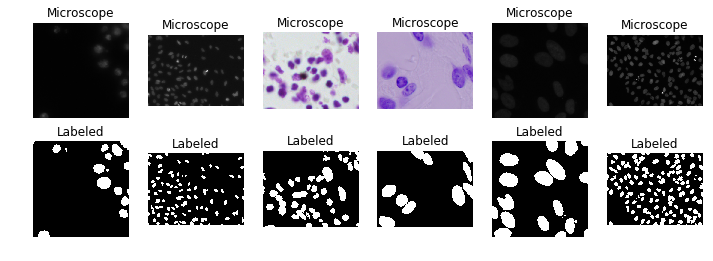

In [4]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [5]:
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []

group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
test_img_df.sample(1)

,ImageId,Stage,images
29,51c70bb8a299943b27f8b354571272692d8f2705036a1a...,stage1,"[[[0.047058823529411764, 0.047058823529411764,..."


(6, 3)


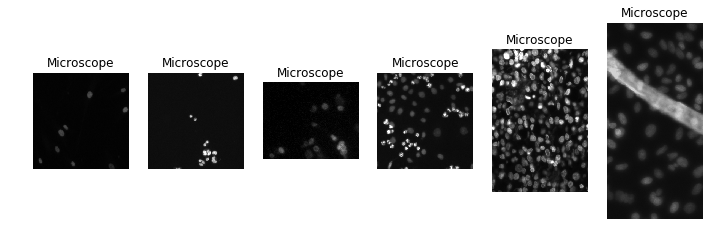

In [6]:
n_img = 6

fig, m_axs = plt.subplots(1, n_img, figsize = (12,4))
print(test_img_df.sample(n_img).shape)

for (_, c_row),(c_im) in zip(test_img_df.sample(n_img).iterrows(),m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis("off")
    c_im.set_title('Microscope')
    

In [7]:
#Temp

print type(train_img_df)
print len(train_img_df)

#import file names for cluster 2 images (bright field)
inf_clust2 = open('EDA_Quentin/cluster_2.txt','r')
clust2_ids = inf_clust2.read().split('\n')[:-1]

print str(clust2_ids[0])
# for img_id in clust2_ids:
#     image = train_img_df.query('ImageId=='+img_id)
image = train_img_df.query('ImageId=="'+clust2_ids[0]+'"')
#image = train_img_df.query('ImageId=="2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812"')
#image = train_img_df[train_img_df['ImageId'] == "2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812"]

plt.figure()
plt.imshow(image['images'].values[0])

#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe

<class 'pandas.core.frame.DataFrame'>
670


IOError: [Errno 2] No such file or directory: 'EDA_Quentin/cluster_2.txt'

In [ ]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Std'] = train_img_df['images'].map(lambda x: np.std(x))

test_img_df['Red'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
test_img_df['Green'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
test_img_df['Blue'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
test_img_df['Gray'] = test_img_df['images'].map(lambda x: np.mean(x))
test_img_df['Std'] = test_img_df['images'].map(lambda x: np.std(x))

plt.figure(1)
plt.subplot(4,2,1)
plt.hist(train_img_df['Red'])
plt.title('Training Data') 
plt.ylabel('Red')

plt.subplot(4,2,2)
plt.hist(test_img_df['Red'])
plt.title('Testing Data')

plt.subplot(4,2,3)
plt.hist(train_img_df['Green'])
plt.ylabel('Green')

plt.subplot(4,2,4)
plt.hist(test_img_df['Green'])

plt.subplot(4,2,5)
plt.hist(train_img_df['Blue'])
plt.ylabel('Blue')

plt.subplot(4,2,6)
plt.hist(test_img_df['Blue'])

plt.subplot(4,2,7)
plt.hist(train_img_df['Gray'])
plt.ylabel('Gray')
plt.xlabel('Pixel Intensity')

plt.subplot(4,2,8)
plt.hist(test_img_df['Gray'])
plt.xlabel('Pixel Intensity')


In [ ]:
#Picking out a specific image to look at the color intensities of the image
#Looking at a H&E stain
selected_image = train_img_df.query('ImageId=="00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In H&E Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')
#test_img_df.query('')



In [ ]:
#Looking at fluorescent stain
selected_image = train_img_df.query('ImageId=="0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Fluorescent Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')

In [ ]:
#Looking at other staining in testing data
selected_image = test_img_df.query('ImageId=="44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Other Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')

In [ ]:
#Looking at other staining in testing data
selected_image = test_img_df.query('ImageId=="3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Other Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')

Separate the training set images into 3 clusters (modalities). The clustering results are obtained through methods in kernel: https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering

In [ ]:
#import file names for all three types of images in the training set
inf_clust0 = open('EDA_Quentin/cluster_0.txt','r')
clust0_ids = inf_clust0.read().split('\n')[:-1]
inf_clust1 = open('EDA_Quentin/cluster_1.txt','r')
clust1_ids = inf_clust1.read().split('\n')[:-1]
inf_clust2 = open('EDA_Quentin/cluster_2.txt','r')
clust2_ids = inf_clust2.read().split('\n')[:-1]


#cluster 0 images (fluorescent)
train_img_df_0 = train_img_df[train_img_df['ImageId'].isin(clust0_ids)]
#cluster 1 images (histological)
train_img_df_1 = train_img_df[train_img_df['ImageId'].isin(clust1_ids)]
#cluster 2 images (bright field)
train_img_df_2 = train_img_df[train_img_df['ImageId'].isin(clust2_ids)]

print len(train_img_df_0)
print len(train_img_df_1)
print len(train_img_df_2)

# image = train_img_df_2[train_img_df_2['ImageId'] == "2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812"]
# plt.figure()
# plt.imshow(image['images'].values[0])

#print train_img_df['ImageId'] == "2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812"

Show the RGB and intensity statistics of each image modality

In [ ]:
train_img_df_0['Red'] = train_img_df_0['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df_0['Green'] = train_img_df_0['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df_0['Blue'] = train_img_df_0['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df_0['Gray'] = train_img_df_0['images'].map(lambda x: np.mean(x))
train_img_df_0['Std'] = train_img_df_0['images'].map(lambda x: np.std(x))

train_img_df_1['Red'] = train_img_df_1['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df_1['Green'] = train_img_df_1['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df_1['Blue'] = train_img_df_1['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df_1['Gray'] = train_img_df_1['images'].map(lambda x: np.mean(x))
train_img_df_1['Std'] = train_img_df_1['images'].map(lambda x: np.std(x))

train_img_df_2['Red'] = train_img_df_2['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df_2['Green'] = train_img_df_2['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df_2['Blue'] = train_img_df_2['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df_2['Gray'] = train_img_df_2['images'].map(lambda x: np.mean(x))
train_img_df_2['Std'] = train_img_df_2['images'].map(lambda x: np.std(x))


plt.figure(2)
plt.subplot(4,3,1)
plt.hist(train_img_df_0['Red'])
plt.title('Training Data - Fluorescent') 
plt.ylabel('Red')

plt.subplot(4,3,2)
plt.hist(train_img_df_1['Red'])
plt.title('Training Data - Histological')

plt.subplot(4,3,3)
plt.hist(train_img_df_2['Red'])
plt.title('Training Data - Bright Field')

plt.subplot(4,3,4)
plt.hist(train_img_df_0['Green'])
plt.ylabel('Green')

plt.subplot(4,3,5)
plt.hist(train_img_df_1['Green'])

plt.subplot(4,3,6)
plt.hist(train_img_df_2['Green'])


plt.subplot(4,3,7)
plt.hist(train_img_df_0['Blue'])
plt.ylabel('Blue')

plt.subplot(4,3,8)
plt.hist(train_img_df_1['Blue'])

plt.subplot(4,3,9)
plt.hist(train_img_df_2['Blue'])


plt.subplot(4,3,10)
plt.hist(train_img_df_0['Gray'])
plt.ylabel('Gray')
plt.xlabel('Pixel Intensity')

plt.subplot(4,3,11)
plt.hist(train_img_df_1['Gray'])
plt.xlabel('Pixel Intensity')

plt.subplot(4,3,12)
plt.hist(train_img_df_2['Gray'])
plt.xlabel('Pixel Intensity')

In [8]:
from skimage.morphology import watershed, dilation, disk
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.filters import rank

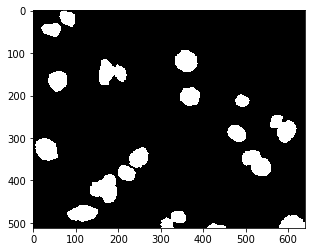

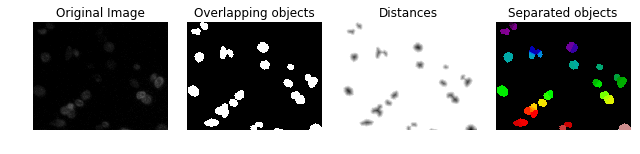

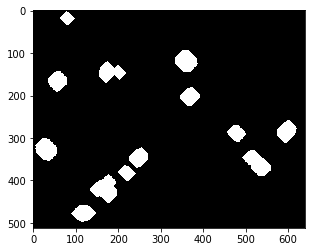

In [52]:
image = train_img_df['masks'][90]
real_image = train_img_df['images'][90]

plt.figure()
plt.imshow(image)

#denoised = rank.median(image, disk(2))
#plt.figure()
#plt.imshow(denoised)
#for image in 

#dilated_image = dilation(image,disk(1))
#plt.figure()
#plt.imshow(dilated_image)

distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image, compactness = 200)

fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(real_image)
ax[0].set_title('Original Image')
ax[1].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Overlapping objects')
ax[2].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Distances')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[3].set_title('Separated objects')


for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

cell_mask_opened = ndi.binary_opening(image, iterations=16)
plt.figure()
plt.imshow(cell_mask_opened)
